# Classification. Linear models and KNN

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.metrics import plot_confusion_matrix, accuracy_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler, OneHotEncoder

## Part 1: Implementing Logistic Regression

In this task you need to implement Logistic Regression with l2 regularization using gradient descent algorithm.

Logistic Regression loss:
$$ L(w) = \dfrac{1}{N}\sum_{i=1}^N \log(1 + e^{-\langle w, x_i \rangle y_i}) + \frac{1}{2C} \lVert w \rVert^2  \to \min_w$$
$$\langle w, x_i \rangle = \sum_{j=1}^n w_{j}x_{ij} + w_{0},$$ $$ y_{i} \in \{-1, 1\}$$ where $n$ is the number of features and $N$ is the number of samples.

Gradient descent step:
$$w^{(t+1)} := w^{(t)} + \dfrac{\eta}{N}\sum_{i=1}^N y_ix_i \Big(1 - \dfrac{1}{1 + exp(-\langle w^{(t)}, x_i \rangle y_i)}\Big) - \eta \frac{1}{C} w,$$
where $\eta$ is the learning rate.

**(2 points)** Implement the algorithm and use it to classify the digits (https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html) into "even" and "odd" categories. "Even" and "Odd" classes  should correspond to {-1, 1} labels.

Stopping criteria: either the number of iterations exceeds *max_iter* or $||w^{(t+1)} - w^{(t)}||_2 < tol$.

In [3]:
from sklearn.exceptions import NotFittedError

In [4]:
class CustomLogisticRegression:
    _estimator_type = "classifier"
    
    def __init__(self, eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False):
        """Logistic Regression classifier.
        
        Args:
            eta: float, default=0.001
                Learning rate.
            max_iter: int, default=1000
                Maximum number of iterations taken for the solvers to converge.
            C: float, default=1.0
                Inverse of regularization strength; must be a positive float.
                Smaller values specify stronger regularization.
            tol: float, default=1e-5
                Tolerance for stopping criteria.
            random_state: int, default=42
                Random state.
            zero_init: bool, default=False
                Zero weight initialization.
        """
        self.eta = eta
        self.max_iter = max_iter
        self.C = C
        self.tol = tol
        self.random_state = np.random.RandomState(seed=random_state)
        self.zero_init = zero_init
         
    def get_sigmoid(self, X, weights):
        """Compute the sigmoid value."""
        # <your code>
        return 1 / (1 + np.exp(-X @ weights))

    def get_loss(self, x, weights, y):
        """Calculate the loss."""
        # <your code>
        return np.mean(np.log(1 + np.exp(-x @ weights * y))) + (weights @ weights) ** 0.5 / (2 * self.C)
     
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X]) # a constant feature is included to handle intercept
        num_features = X_ext.shape[1]
        if self.zero_init:
            self.weights_ = np.zeros(num_features) 
        else:
            weight_threshold = 1.0 / (2 * num_features)
            self.weights_ = self.random_state.uniform(low=-weight_threshold,
                                                      high=weight_threshold, size=num_features) # random weight initialization
        
        self.loss_history_ = []
        
        for i in range(self.max_iter):
            
            self.loss_history_.append(self.get_loss(X_ext, self.weights_, y))
            
            term0 = 1 - 1 / (1 + np.exp(-X_ext @ self.weights_ * y))
            term1 = np.mean(np.multiply(X_ext, (y * term0)[:, np.newaxis]), axis=0)
            term2 = self.weights_ / self.C
            
            delta = term1 - term2
            
            self.weights_ += self.eta * delta
            
            d = self.eta * delta
            d = (d @ d) ** 0.5
            
            if (i >= self.max_iter) or (d < self.tol):
                break
     
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing positive class probabilities.
        """
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        if hasattr(self, 'weights_'):
            return self.get_sigmoid(X_ext, self.weights_)
        else: 
            raise NotFittedError("CustomLogisticRegression instance is not fitted yet")
    
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        X_ext = np.hstack([np.ones((X.shape[0], 1)), X])
        preds = self.get_sigmoid(X_ext, self.weights_)
        preds[preds >= 0.5] = 1
        preds[preds < 0.5] = -1
        return preds

In [5]:
from sklearn import datasets
from sklearn import metrics

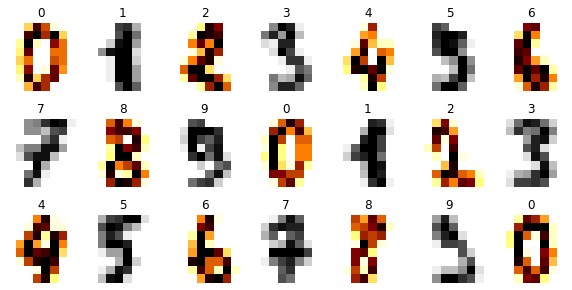

In [6]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)
#y_train = "<your code>"
#y_test = "<your code>"
y_train = (y_train % 2) * 2 - 1
y_test = (y_test % 2) * 2 - 1

In [7]:
assert (np.unique(y_train) == [-1, 1]).all()
assert (np.unique(y_test) == [-1, 1]).all()

In [8]:
def fit_evaluate(clf, X_train, y_train, X_test, y_test):
    clf.fit(X_train, y_train)
    disp = metrics.plot_confusion_matrix(clf, X_test, y_test, normalize='true')
    disp.figure_.suptitle("Confusion Matrix")
    plt.show()
    
    return metrics.accuracy_score(y_pred=clf.predict(X_train), y_true=y_train), \
           metrics.accuracy_score(y_pred=clf.predict(X_test), y_true=y_test)

In [9]:
lr_clf = CustomLogisticRegression(max_iter=1, zero_init=True)

In [10]:
assert np.allclose(lr_clf.get_sigmoid(np.array([[0.5, 0, 1.0], [0.3, 1.3, 1.0]]), np.array([0.5, -0.5, 0.1])),
                   np.array([0.58662, 0.40131]))

In [11]:
lr_clf.fit(X_train, y_train)

In [12]:
assert np.allclose(lr_clf.weights_, np.array([ 3.1000e-06,  0.0000e+00,  4.1800e-05,  5.4770e-04,  2.2130e-04,
        4.8750e-04,  1.3577e-03,  5.9780e-04,  5.6400e-05, -7.0000e-07,
        1.6910e-04,  2.5190e-04, -4.3700e-04,  3.6190e-04,  1.0049e-03,
        4.2280e-04,  2.5700e-05,  3.0000e-07, -1.1500e-05, -7.2440e-04,
       -2.6200e-04,  8.7540e-04,  4.1540e-04, -8.4200e-05, -5.2000e-06,
        0.0000e+00, -2.2160e-04, -5.7130e-04,  9.8570e-04,  1.3507e-03,
        5.0210e-04, -1.7050e-04, -1.0000e-06,  0.0000e+00, -6.7810e-04,
       -1.0515e-03, -4.4500e-05,  3.7160e-04,  4.2100e-04, -8.1800e-05,
        0.0000e+00, -5.2000e-06, -5.3410e-04, -2.0393e-03, -8.4310e-04,
        1.0400e-04, -1.2390e-04, -1.7880e-04, -1.3200e-05, -4.5000e-06,
       -9.4300e-05, -1.1127e-03, -5.0900e-04, -2.1850e-04, -5.6050e-04,
       -3.9560e-04, -1.7700e-05, -3.0000e-07,  2.6800e-05,  6.3920e-04,
        1.8090e-04, -7.3660e-04, -5.3930e-04, -3.7060e-04, -2.8200e-05]), atol=1e-5)

In [13]:
model = CustomLogisticRegression()

C:\Users\A\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


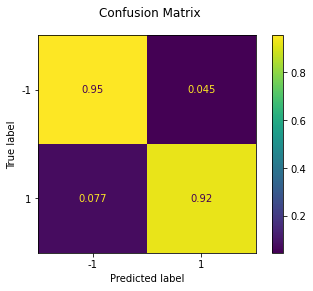

In [14]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [15]:
train_acc, test_acc

(0.9109255393180237, 0.9388888888888889)

In [16]:
assert min(train_acc, test_acc) > 0.9

**(0.5 points)** Visualize the loss history.

Text(0, 0.5, 'Loss')

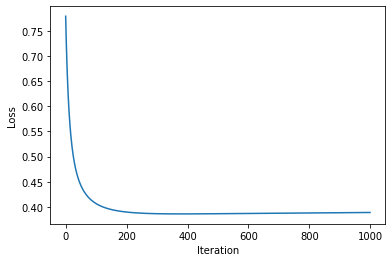

In [17]:
## your code

sns.lineplot(data=model.loss_history_)
plt.xlabel("Iteration")
plt.ylabel("Loss")

**(0.5 points)** Try different learning rates and compare the results. How does the learning rate influence the convergence?

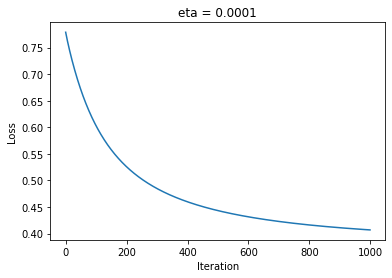

0.8844815588030619 0.9111111111111111 1000


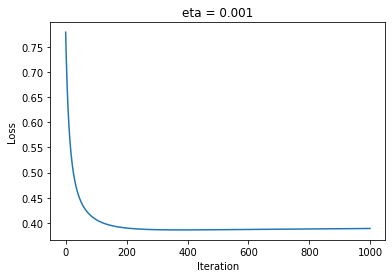

0.9109255393180237 0.9388888888888889 1000


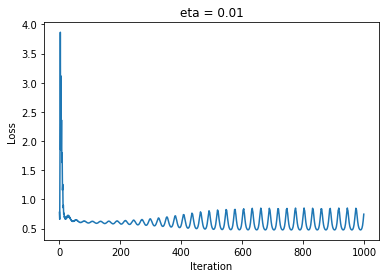

0.7731384829505915 0.7527777777777778 1000


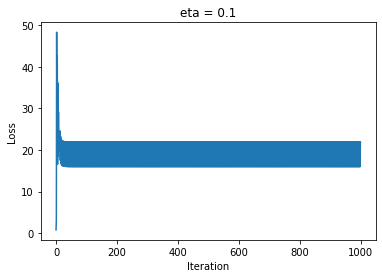

0.5455810716771051 0.5277777777777778 1000


In [18]:
## your code

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

for i in range(-4, 0):
    
    eta = 10 ** i
    model = CustomLogisticRegression(eta=eta)
    model.fit(X_train, y_train)
    
    #train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
    
    train_acc, test_acc = metrics.accuracy_score(y_pred=model.predict(X_train), y_true=y_train), \
                          metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)
    sns.lineplot(data=model.loss_history_).set_title(f'eta = {eta}')
    plt.xlabel("Iteration")
    plt.ylabel("Loss")
    plt.show()
    print(train_acc, test_acc, len(model.loss_history_))

< your thoughts >

При eta=0.0001 оптимум не был достигнут за 1000 итераций.
При eta=0.001 модель сошлась за меннее чем 400 итераций.
При следующих значениях learning rate модель не сходится.
Слишком низкий learning rate приводит к тому, что что требуется очень большое количество итераций для нахождения оптимальных весов. А слишком высокий в принципе исключает сходимость.



**(0.5 points)** Try different regularization parameter values and compare the model quality.

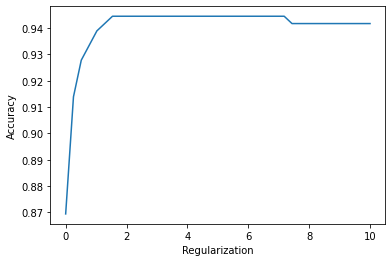

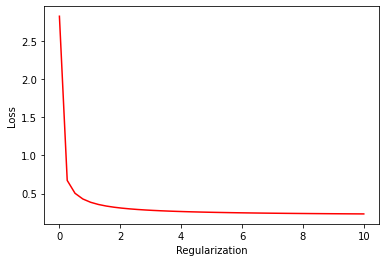

In [19]:
## your code

acc_history = []
loss_history = []
R = np.linspace(0.001, 10, 40)

for C in R:

    model = CustomLogisticRegression(C=C)
    model.fit(X_train, y_train)
    
    test_acc = metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)
    
    acc_history.append(test_acc)
    loss_history.append(model.loss_history_[-1])
    
sns.lineplot(x=R, y=acc_history)
plt.xlabel("Regularization")
plt.ylabel("Accuracy")
plt.show()

sns.lineplot(x=R, y=loss_history, color='r')
plt.xlabel("Regularization")
plt.ylabel("Loss")
plt.show()

< your thoughts >

Наилучшая точность получается при регуляризцаии от 2 до 7. При меньших значениях регуляризация слишком сильная, что снижает точность. При значениях выше 7 точность немного падает, т.к. слабая регуляризация увеличивает variance.

Функция потерь только уменьшаетя при ослаблении регуляризации и в дальнейшем не возрастает, что означает что модель хорошо подстраивается к обучающим данным.

**(0.5 points)** Compare zero initialization and random initialization. 

Zero init test score:  0.8972222222222223
Random init test score:  0.8972222222222223
Zero init vs random init weights distance:  0.00087438370896025


<AxesSubplot:xlabel='Iteration', ylabel='Loss'>

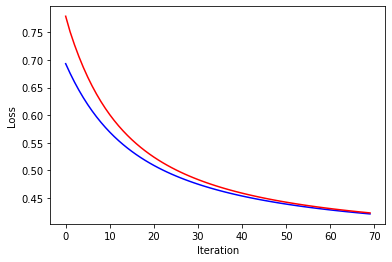

In [20]:
## your code

#eta=0.001, max_iter=1000, C=1.0, tol=1e-5, random_state=42, zero_init=False

model1 = CustomLogisticRegression(zero_init=True, max_iter=70)
model1.fit(X_train, y_train)
test_acc1 = metrics.accuracy_score(y_pred=model1.predict(X_test), y_true=y_test)

model2 = CustomLogisticRegression(zero_init=False, max_iter=70)
model2.fit(X_train, y_train)
test_acc2 = metrics.accuracy_score(y_pred=model1.predict(X_test), y_true=y_test)

print('Zero init test score: ', test_acc1)
print('Random init test score: ', test_acc2)

wd = np.sum((model1.weights_ - model2.weights_) ** 2)
print('Zero init vs random init weights distance: ', wd)

sns.lineplot(data=model1.loss_history_, color='b')
plt.xlabel("Iteration")
plt.ylabel("Loss")
sns.lineplot(data=model2.loss_history_, color='r')

< your thoughts >

При нулевой инициализации функция потерь немного ниже на первых 40 итерациях. Преимуществом такой инициализации может быть то, что изначальные вероятности будут равны для всех образцов, что кажется логичным для необученной модели. Однако уже после 70 итераций модели почти идентичны.

## Part 2: Implementing KNN Classifier

In this task you need to implement weighted K-Neighbors Classifier.

Recall that training a KNN classifier is simply memorizing a training sample. 

The process of applying a classifier for one object is to find the distances from it to all objects in the training data, then select the k nearest objects (neighbors) and return the most common class among these objects.

You can also give the nearest neighbors weights in accordance with the distance of the object to them. In the simplest case (as in your assignment), you can set the weights inversely proportional to that distance. 

$$w_{i} = \frac{1}{d_{i} + eps},$$

where $d_{i}$ is the distance between object and i-th nearest neighbor and $eps$ is the small value to prevent division by zero.

In case of 'uniform' weights, all k nearest neighbors are equivalent (have equal weight, for example $w_{i} = 1, \forall i \in(1,k)$).

To predict the probability of classes, it is necessary to normalize the weights of each class, dividing them by the sum:

$$p_{i} = \frac{w_{i}}{\sum_{j=1}^{c}w_{j}},$$

where $p_i$ is probability of i-th class and $c$ is the number of classes.

**(2 points)** Implement the algorithm and use it to classify the digits. By implementing this algorithm, you will be able to classify numbers not only into "even" or "odd", but into their real representation.

In [21]:
class CustomKNeighborsClassifier:
    _estimator_type = "classifier"
    
    def __init__(self, n_neighbors=5, weights='uniform', eps=1e-9):
        """K-Nearest Neighbors classifier.
        
        Args:
            n_neighbors: int, default=5
                Number of neighbors to use by default for :meth:`kneighbors` queries.
            weights : {'uniform', 'distance'} or callable, default='uniform'
                Weight function used in prediction.  Possible values:
                - 'uniform' : uniform weights.  All points in each neighborhood
                  are weighted equally.
                - 'distance' : weight points by the inverse of their distance.
                  in this case, closer neighbors of a query point will have a
                  greater influence than neighbors which are further away.
            eps : float, default=1e-5
                Epsilon to prevent division by 0 
        """
        self.n_neighbors = n_neighbors
        self.weights = weights
        self.eps = eps
        
    
    def get_pairwise_distances(self, X, Y):
        """
        Returnes matrix of the pairwise distances between the rows from both X and Y.
        Args:
            X: numpy array of shape (n_samples, n_features)
            Y: numpy array of shape (k_samples, n_features)
        Returns:
            P: numpy array of shape (n_samples, k_samples)
                Matrix in which (i, j) value is the distance 
                between i'th row from the X and j'th row from the Y.
        """
        # <your code>
        d = np.sum(X**2, axis=1)[:, np.newaxis] + np.sum(Y**2, axis=1) - 2 * X @ Y.T
        #from scipy.spatial.distance import cdist
        #d = cdist(X, Y, 'euclidean')
        return d ** 0.5
    
    
    def get_class_weights(self, y, weights):
        """
        Returns a vector with sum of weights for each class 
        Args:
            y: numpy array of shape (n_samles,)
            weights: numpy array of shape (n_samples,)
                The weights of the corresponding points of y.
        Returns:
            p: numpy array of shape (n_classes)
                Array where the value at the i-th position 
                corresponds to the weight of the i-th class.
        """
        # <your code>
        p = np.zeros(len(self.classes_))
        
        s = np.argsort(self.classes_)
        class_ind = s[np.searchsorted(self.classes_, y, sorter=s)]
        
        np.add.at(p, class_ind, weights)
        
        return p
            
        
    def fit(self, X, y):
        """Fit the model.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
            y: numpy array of shape (n_samples,)
                Target vector.        
        """
        self.points = X
        self.y = y
        self.classes_ = np.unique(y)
        
        
    def predict_proba(self, X):
        """Predict positive class probabilities.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples, n_classes)
                Vector containing positive class probabilities.
        """
        if hasattr(self, 'points'):
            P = self.get_pairwise_distances(X, self.points)
            
            weights_of_points = np.ones(P.shape)
            if self.weights == 'distance':
                weights_of_points = weights_of_points / (P  + self.eps)
                
            # <your code>
            nn = np.argsort(P)[:, :self.n_neighbors]
            preds = np.zeros([P.shape[0], len(self.classes_)])
            
            for sample, nearest in enumerate(nn):
                preds[sample] = self.get_class_weights(self.y[nearest], weights_of_points[sample][nearest])
                preds[sample] /= np.sum(preds[sample])
                
            return preds

        else: 
            raise NotFittedError("CustomKNeighborsClassifier instance is not fitted yet")
            
        
    def predict(self, X):
        """Predict classes.
        
        Args:
            X: numpy array of shape (n_samples, n_features)
        Returns:
            y: numpy array of shape (n_samples,)
                Vector containing predicted class labels.
        """
        # <your code>
        probs = self.predict_proba(X)
        return np.argmax(probs, axis=1)
    

In [22]:
model = CustomKNeighborsClassifier(n_neighbors=5, weights='distance')
knn = KNeighborsClassifier(n_neighbors=5, weights='distance')

In [23]:
assert np.allclose(model.get_pairwise_distances(np.array([[0  , 1]  , [1, 1]]), 
                                                np.array([[0.5, 0.5], [1, 0]])),
                   np.array([[0.70710678, 1.41421356],
                             [0.70710678, 1.        ]]))

In [24]:
model.classes_ = ['one', 'two', 'three']
assert np.allclose(model.get_class_weights(np.array(['one', 'one', 'three', 'two']), np.array([1, 1, 0, 4])), 
                   np.array([2,4,0]))

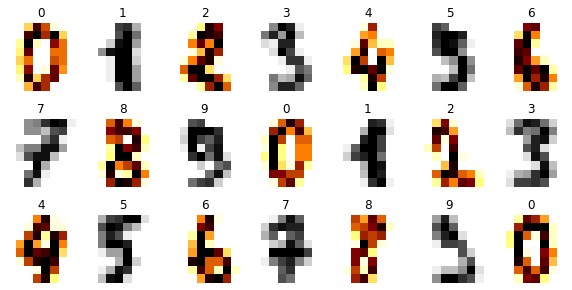

In [25]:
X, y = datasets.load_digits(n_class=10, return_X_y=True)

_, axes = plt.subplots(nrows=3, ncols=7, figsize=(10, 5))
for ax, image, label in zip(axes.flatten(), X, y):
    ax.set_axis_off()
    ax.imshow(image.reshape((8, 8)), cmap=plt.cm.gray_r if label % 2 else plt.cm.afmhot_r)
    ax.set_title(label)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42)

In [26]:
model.fit(X_train, y_train)
knn.fit(X_train, list(map(str, y_train)));

In [27]:
assert np.allclose(model.predict_proba(X_test), knn.predict_proba(X_test))

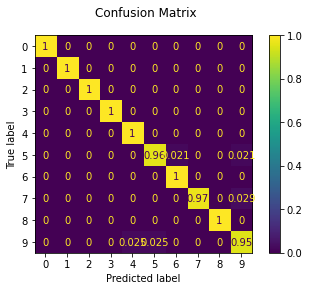

In [28]:
train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)

In [29]:
assert train_acc == 1
assert test_acc > 0.98

**(0.5 points)** Take a look at the confusion matrix and tell what numbers the model confuses and why this happens.

< your thoughts >

Цифра 5 в некоторых случаях классифицируется как 6 или 9. Из-за сходства этих цифр у них должны быть схожие участки на изображении, что может приводиить к близкому расположению при использовании KNN.

Цифра 9 иногда классифицируется как 4 или 5.

Цифра 7 очень редко классифицируется как 9. Тут сходство очень небольшое.

Также неправильно классифицироваться могут "неправильно написанные" цифры, которы располагаются далеко от всех образцов того же класса из обучающей выборки.

**(0.5 points)** Try different n_neighbors parameters and compare the output probabilities of the model.

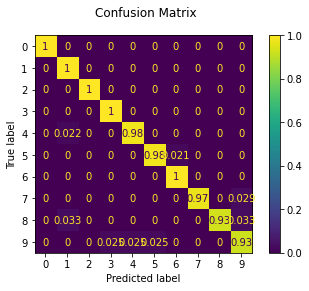

1.0 train  0.9777777777777777 test  1 nn


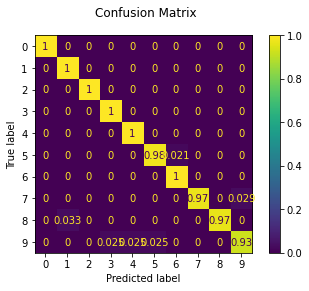

1.0 train  0.9833333333333333 test  3 nn


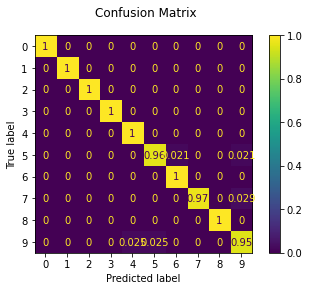

1.0 train  0.9861111111111112 test  5 nn


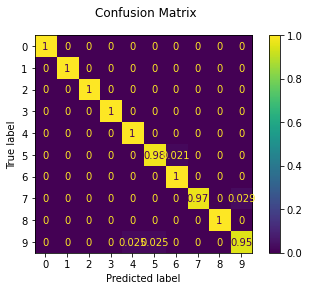

1.0 train  0.9888888888888889 test  7 nn


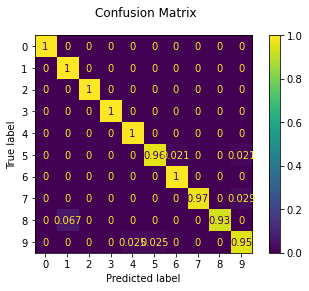

1.0 train  0.9805555555555555 test  9 nn


In [30]:
## your code

for nn in range(1, 10, 2):
    model = CustomKNeighborsClassifier(n_neighbors=nn, weights='distance')
    
    train_acc, test_acc = fit_evaluate(model, X_train, y_train, X_test, y_test)
    print(train_acc, 'train ', test_acc, 'test ', nn, 'nn')

< your thoughts >

Тут наилучшим является выбор 7 ближайших соседей. При повышении n_neighbors до 7 постепенно пропадают некоторые несответствия между предсказанным классом и настоящим классом.

**(0.5 points)** Compare both 'uniform' and 'distance' weights and share your thoughts in what situations which parameter can be better.

0.9888888888888889 0.9888888888888889


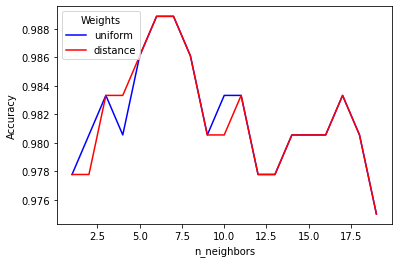

In [31]:
## your code

scores_uniform, scores_distance = [], []

R = np.arange(1, 20)

for nn in R:
    
    model = CustomKNeighborsClassifier(n_neighbors=nn, weights='uniform')
    model.fit(X_train, y_train)

    train_acc, test_acc = metrics.accuracy_score(y_pred=model.predict(X_train), y_true=y_train), \
                          metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)
    scores_uniform.append(test_acc)

    model = CustomKNeighborsClassifier(n_neighbors=nn, weights='distance')
    model.fit(X_train, y_train)

    train_acc, test_acc = metrics.accuracy_score(y_pred=model.predict(X_train), y_true=y_train), \
                          metrics.accuracy_score(y_pred=model.predict(X_test), y_true=y_test)
    scores_distance.append(test_acc)
    
sns.lineplot(x=R, y=scores_uniform, color='b')
sns.lineplot(x=R, y=scores_distance, color='r')
plt.xlabel("n_neighbors")
plt.ylabel("Accuracy")
plt.legend(title='Weights', loc='upper left', labels=['uniform', 'distance'])

print(max(scores_uniform), max(scores_distance))

< your thoughts >

При наилучшем подборе параметра n_neighbors оба варианта дали одинаковую точность. В остальных случаях они могут вести себя по-разному. Наилучший выбор параметра weights может быть различным для разных данных. Если классы плохо разделяются, то возможно следует выбрать uniform. 

**(0.5 points)** Suggest another distance measurement function that could improve the quality of the classification for this task. 

< your thoughts >

Можно попробовать функцию, предназначенную для целочисленных признаков. Hamming distance, Canberra distance, Bray-Curtis distance. 

**(0.5 points)** Suggest different task and distance function that you think would be suitable for it.

< your thoughts >

Возможно, при анализе шахматных партий будет уместно использование manhattan distance.

## Part 3: Synthetic Titanic Survival Prediction

### Dataset

Read the description here: https://www.kaggle.com/c/tabular-playground-series-apr-2021/data. Download the dataset and place it in the *data/titanic/* folder in your working directory.
You will use train.csv for model training and validation. The test set is used for model testing: once the model is trained, you can predict whether a passenger survived or not for each passenger in the test set, and submit the predictions: https://www.kaggle.com/c/tabular-playground-series-apr-2021/overview/evaluation.  


In [32]:
PATH = "../data/"

In [33]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')

In [34]:
data.head()

Survived  Pclass              Name   Sex    Age  SibSp  Parch  \
PassengerId                                                                  
0                   1       1  Oconnor, Frankie  male    NaN      2      0   
1                   0       3       Bryan, Drew  male    NaN      0      0   
2                   0       3    Owens, Kenneth  male   0.33      1      2   
3                   0       3     Kramer, James  male  19.00      0      0   
4                   1       3     Bond, Michael  male  25.00      0      0   

                Ticket   Fare   Cabin Embarked  
PassengerId                                     
0               209245  27.14  C12239        S  
1                27323  13.35     NaN        S  
2            CA 457703  71.29     NaN        S  
3             A. 10866  13.04     NaN        S  
4               427635   7.76     NaN        S

### EDA

**(0.5 points)** How many females and males are there in the dataset? What about the survived passengers? Is there any relationship between the gender and the survival?

In [35]:
## your code

data.Sex.value_counts()

male      56114
female    43886
Name: Sex, dtype: int64

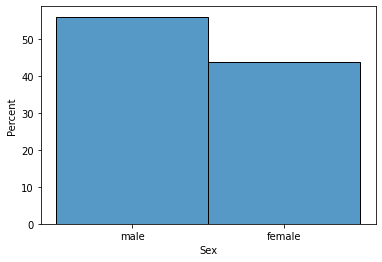

<AxesSubplot:xlabel='Sex', ylabel='Survived'>

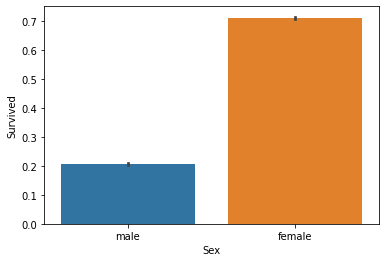

In [36]:
sns.histplot(x=data.Sex, stat = 'percent')
plt.show()

sns.barplot(x=data.Sex, y=data.Survived)

< your thoughts >

Мужчин среди пассажиров больше. Их доля составляет 56 процентов, что вносит некоторый дисбаланс в данные. Выживаемость существенно зависит от пола: 20 процентов у мужчин и 70 процентов у женщин. Это объясняется тем, что во время эвакуации приоритет дается женщинам и детям.

**(0.5 points)** Plot age distribution of the passengers. What is the average and the median age of survived and deceased passengers? Do age distributions differ for survived and deceased passengers? Why?

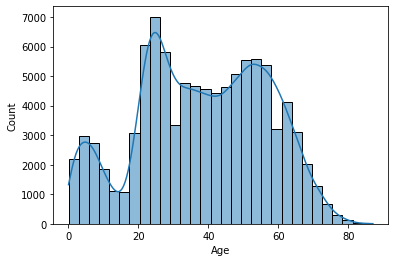

Выжившие: медиана  43.0  среднее  40.553799314307795
Погибшие: медиана  36.0  среднее  36.70869488153374


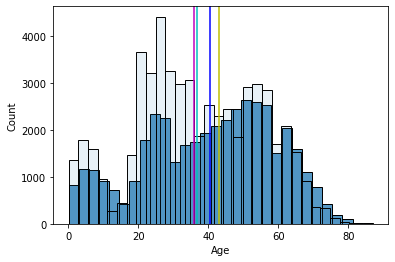

In [37]:
## your code

sns.histplot(x=data.Age, kde=True, bins=30)
plt.show()

a = data.loc[data.Survived == 1, 'Age']
print('Выжившие: медиана ', a.median(), ' среднее ', a.mean())
sns.histplot(x=a, kde=False, bins=30)
plt.axvline(x=a.median(), color='y')
plt.axvline(x=a.mean(), color='b')
#plt.show()

a = data.loc[data.Survived == 0, 'Age']
print('Погибшие: медиана ', a.median(), ' среднее ', a.mean())
sns.histplot(x=a, kde=False, bins=30, alpha=0.1)
plt.axvline(x=a.median(), color='m')
plt.axvline(x=a.mean(), color='c')

< your thoughts >

У выживших средний возраст больше на 4 года, а медиана на 7 лет. Распределения возраста имеют различную форму. В группе 20-35 лет процент выживших самый низкий. Также возраст меньше 10 и между 50-60 лет отличается более высокой смертностью. У более возрастных пассажиров выживаемость выше. Причиной может быть распределение пола, класса билета и других факторов внутри разных возрастных групп, а также особенности эвакуации пассажиров. Что и дает различные распределения.

**(1 point)** Explore "passenger class" and "embarked" features. What class was "the safest"? Is there any relationship between the embarkation port and the survival? Provide the corresponding visualizations.

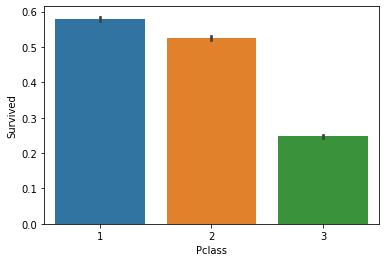

<AxesSubplot:xlabel='Embarked', ylabel='Survived'>

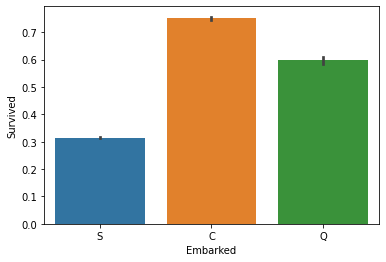

In [38]:
## your code

sns.barplot(x=data.Pclass, y=data.Survived)
plt.show()
sns.barplot(x=data.Embarked, y=data.Survived)

< your thoughts >

Оба признака различаются по выживаемости внутри групп. Между классами билета 1 и 2 разница не столь велика, как между 2 и 3 классом. Порты посадки тоже связаны с выживаемостью, что может быть вызвано различиями по другим признакам между группами.

### Modelling

**(0.5 points)** Find the percentage of missing values for each feature. 

In [39]:
## your code

data.isnull().sum() * 100 / len(data)

Survived     0.000
Pclass       0.000
Name         0.000
Sex          0.000
Age          3.292
SibSp        0.000
Parch        0.000
Ticket       4.623
Fare         0.134
Cabin       67.866
Embarked     0.250
dtype: float64

Think about the ways to handle these missing values for modelling and write your answer below. Which methods would you suggest? What are their advantages and disadvantages?

< your thoughts >

В колонке Cabin очень много пропущенных значений, поэтому можно создать признак, кодирующий пропущенные значения, а Cabin заполнить уникальным значением. Пропущенные номера билетов можно заполнить любым уникальным значением. Возраст разумно взять средний с учетом класса билета и пола. Embarked предлагаю заполнить модой, поскольку он категориальный, а Fare медианой, т.к. этот признак сильно скошен.

**(1.5 points)** Prepare the features and train two models (KNN and Logistic Regression) to predict the survival. Compare the results. Use accuracy as a metric. Don't forget about cross-validation!

In [40]:
# your code

# Заполнение пропущенных значений

def na_replace(data):

    data['Cabin'].fillna('NA', inplace=True)
    data['Ticket'].fillna('NA', inplace=True)

    data['Embarked'].fillna(data['Embarked'].mode()[0], inplace=True)

    data['Age'] = data.groupby(['Pclass', 'Sex'])['Age'].apply(lambda x: x.fillna(x.mean()))

    data['Fare'] = data.groupby(['Pclass', 'Sex'])['Fare'].apply(lambda x: x.fillna(x.median()))

    data['Sex'].replace({'male': 0, 'female': 1}, inplace=True)
    data['Embarked'].replace({'S': 0, 'Q': 1, 'C': 2}, inplace=True)
    
    return

# Колонки для тренировки модели
cols = ['Sex', 'Pclass', 'Embarked', 'Fare', 'Age', 'Parch', 'SibSp']

na_replace(data)

X = data[cols]
y = data.Survived


In [41]:
# KNN классификатор

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score

def pipeline(classifier):
    
    return Pipeline([
        ('sca', StandardScaler()),
        ('clf', classifier)
    ])

knn = KNeighborsClassifier(15, weights='uniform')
results = cross_validate(pipeline(knn), X, y, cv=5, return_train_score=True, scoring='accuracy')
print(np.mean(results['test_score']), nn)

0.76209 19


In [42]:
# LR классификатор

from sklearn.linear_model import LogisticRegression

for C in np.linspace(0.0001, 1, 10):
    lr = LogisticRegression(C=C, max_iter=5000)
    results = cross_validate(pipeline(lr), X, y, cv=5, return_train_score=True, scoring='accuracy')
    print(np.mean(results['test_score']), C)


0.76305 0.0001
0.76711 0.11120000000000001
0.7671 0.2223
0.7671 0.33340000000000003
0.7670899999999999 0.4445
0.76708 0.5556
0.76708 0.6667000000000001
0.76708 0.7778
0.76708 0.8889
0.76708 1.0


Точность логистической регрессии чуть выше, но недостаточно хорошая.

**(0.5 + X points)** Try more feature engineering and hyperparameter tuning to improve the results. You may use either KNN or Logistic Regression (or both).

Select the best model, load the test set and make the predictions. Submit them to kaggle and see the results :)

**Note**. X points will depend on your kaggle public leaderboard score.
$$ f(score) = 1.0, \ \ 0.79 \leq score < 0.80,$$
$$ f(score) = 2.5, \ \ 0.80 \leq score < 0.81,$$ 
$$ f(score) = 4.0, \ \ 0.81 \leq score $$ 
Your code should generate the output submitted to kaggle. Fix random seeds to make the results reproducible.

In [43]:
## your code

In [44]:
# feature engineering

from sklearn.preprocessing import LabelEncoder

def data_transform(data):

    data['Pclass_sex'] = data['Sex'].astype(str) + data['Pclass'].astype(str)

    data['Cabin'] = data.Cabin.str.replace(r'(([a-zA-Z])([0-9]+))', lambda x: x.group(2), regex=True)
    data.columns = data.columns.str.replace('Cabin', 'Deck')

    data['Deck_NA'] = (data['Deck'] == 'NA').astype(int)

    data['Deck'].replace({'E': 1, 'F': 1, 'G': 1, 'T': 1, 'D': 1,
                          'C': 2, 'B': 2, 'NA': 3, 'A': 4}, inplace=True)

    data['Parch_odd'] = data['Parch'] % 2
    data['SibSp_odd'] = data['SibSp'] % 2

    data['Fare'] = pd.qcut(data.Fare, 8)
    le = LabelEncoder()
    data['Fare'] = le.fit_transform(data.Fare)

    data['Age'] = pd.qcut(data.Age, 2)
    le = LabelEncoder()
    data['Age'] = le.fit_transform(data.Age)
    
    data['Fare_Deck'] = data['Fare'].astype(str) + data['Deck'].astype(str)
    le = LabelEncoder()
    data['Fare_Deck'] = le.fit_transform(data.Fare_Deck)

    return

In [45]:
data = pd.read_csv(os.path.join(PATH, 'titanic', 'train.csv')).set_index('PassengerId')
na_replace(data)

data_transform(data)
data = pd.get_dummies(data, columns=['Pclass_sex', 'Fare_Deck'])

y = data.Survived
X = data.drop(columns=['Survived', 'Ticket', 'Name', 'Sex', 'Pclass', 'Fare', 'Deck'])

Создано достаточно много признаков, поэтому использовать KNN будет проблематично. Попробуем логистическую регрессию.

In [46]:
for C in np.linspace(0.0001, 1, 5):
    lr = LogisticRegression(C=C, max_iter=5000)
    results = cross_validate(lr, X, y, cv=5, return_train_score=True, scoring='accuracy')
    print(np.mean(results['test_score']), C)

0.71425 0.0001
0.77751 0.250075
0.7775399999999999 0.50005
0.77766 0.7500249999999999
0.7776500000000001 1.0


In [47]:
# Обучим модель на всех данных

lr = LogisticRegression(C=1, max_iter=10000, random_state=1)
lr.fit(X, y)

test = pd.read_csv(os.path.join(PATH, 'titanic', 'test.csv'))

na_replace(test)

data_transform(test)
test = pd.get_dummies(test, columns=['Pclass_sex', 'Fare_Deck'])

X_test = test.drop(columns=['Ticket', 'Name', 'Sex', 'Pclass', 'Fare', 'Deck', 'PassengerId'])

predictions = lr.predict(X_test)


submission = pd.DataFrame({'PassengerId':test['PassengerId'],'Survived':predictions})

filename = 'Titanic predictions.csv'
submission.to_csv(filename, index=False)


Submitted by askv1 

Score: 0.79423
Public score: 0.79861